## what do we have here?

In [8]:
import networkx as nx
import pandas as pd
import numpy as np

# G = nx.read_edgelist('bst_full_norm.edgelist', create_using=nx.DiGraph)
# G = nx.read_gml('networks/Bike share ridership 2021-02.gml')
# G = nx.read_gml('networks/whole_network.gml')
G = nx.read_gml('Processed/years/average/months/network-4.gml')

# df = pd.read_csv('Processed/years/2019/months/trips-2019-1.csv', index_col=0)
# G, _ = func2(df)

In [9]:
distance_matrix = np.loadtxt('geocoding/distance_matrix_grp.txt')

In [10]:
stations_df = pd.read_csv('Processed/grp_stations.csv', index_col=0).reset_index(drop=True)
stations_df['Id'] = stations_df['Id'].astype('str')

In [11]:
current_stations_df = stations_df[stations_df['Id'].isin(list(G.nodes()))].reset_index(names='old_index')
nodes_indices = current_stations_df['old_index'].to_numpy()
nodes_distances = distance_matrix[np.ix_(nodes_indices, nodes_indices)]

In [12]:
ind_to_key = current_stations_df['Id'].to_dict()
key_to_ind = {v:k for k,v in ind_to_key.items()}

In [13]:
from null_models.maslov_sneppen import double_swap_distances
import time

start = time.time()

G_swap = double_swap_distances(G.copy(), nodes_distances, key_to_ind, ind_to_key, nswap=G.number_of_edges(), max_tries=10 * G.number_of_edges(), keep='in')

end = time.time()

print(end - start)

540.693131685257


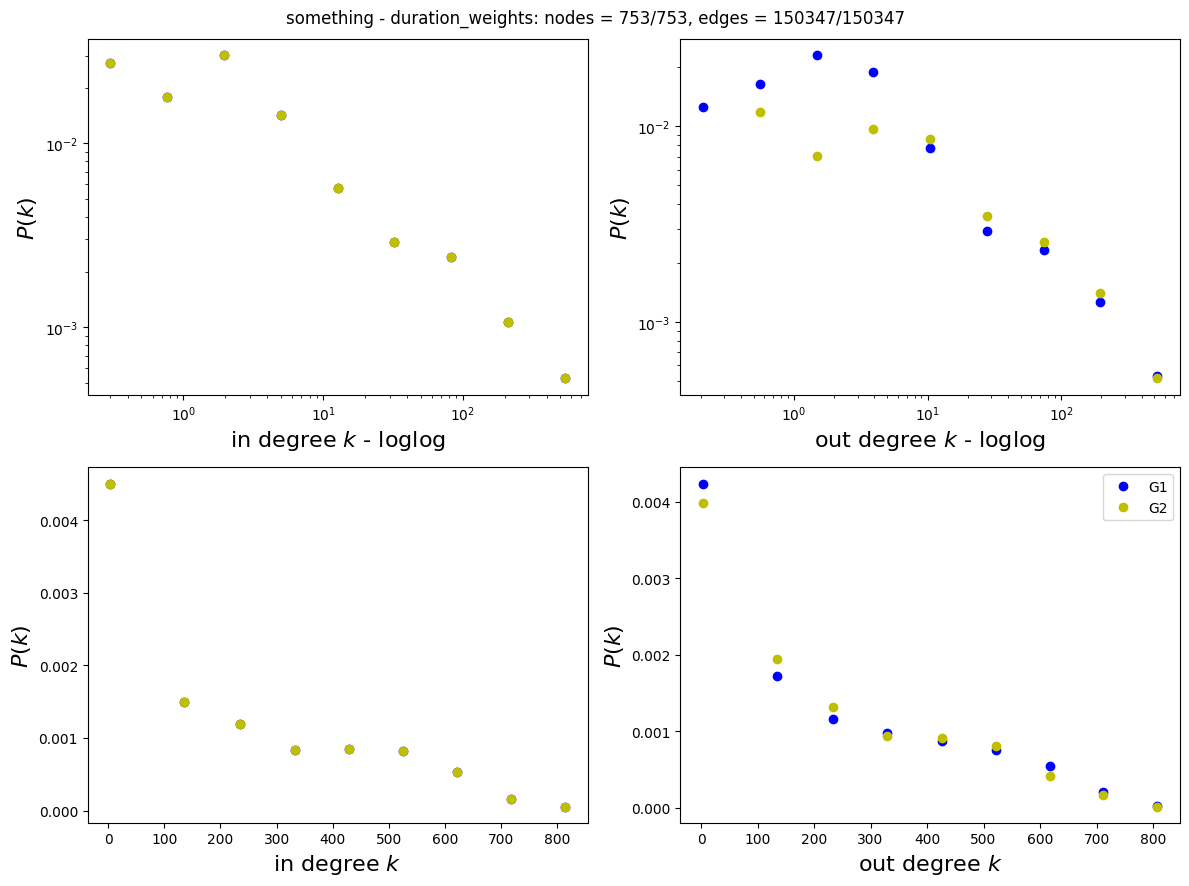

In [15]:
from plotting.distributions import compare_dists

compare_dists(G, G_swap, 'something', weight='duration_weights')

In [36]:
from null_models.strength_preserving import strength_preserving_rand_sa_dir_dist

start = time.time()

G_swap_annealing = strength_preserving_rand_sa_dir_dist(G, nodes_distances, key_to_ind, ind_to_key, weight_list=['duration_weights', 'trip_count_weights', 'tpd_weights'], rewiring_method='double')

end = time.time()

print(end - start)

123.06342720985413


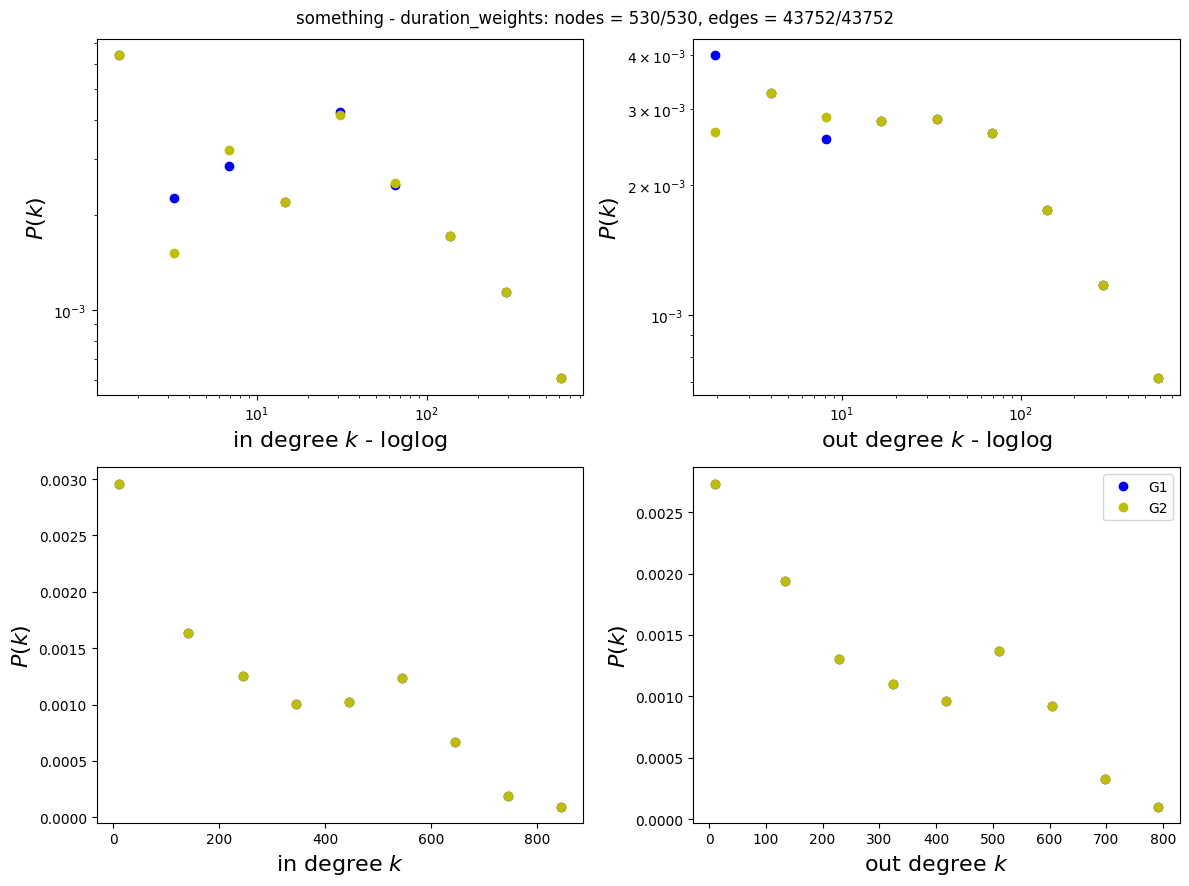

In [37]:
from plotting.distributions import compare_dists

compare_dists(G, G_swap_annealing, 'something', weight='duration_weights')

## let's cook

In [67]:
import multiprocessing as mp
import glob

def do_the_work(filename):
    try:
        df = pd.read_csv(filename, index_col=0)
        G, _ = func2(df)
        nx.write_gml(G, filename.replace('trips','network').replace('csv','gml'))
        return True
    except Exception as e:
        return False
    
files = glob.glob('Processed/**/temp/*.csv', recursive=True)

with mp.Pool() as pool:
    results = pool.map(do_the_work, files, chunksize=1)

In [6]:
import os
len(os.sched_getaffinity(0))

32

In [7]:
import multiprocessing as mp
import glob
import time
import itertools
import os
from null_models.strength_preserving import strength_preserving_rand_sa_dir_dist

def do_the_work(filename, cnt):
    
    try:
        null_name = filename.replace('months', 'months_null').replace('.gml', f"-{str(cnt).zfill(3)}.gml")

        if os.path.isfile(null_name):
            return True
        
        G = nx.read_gml(filename)

        current_stations_df = stations_df[stations_df['Id'].isin(list(G.nodes()))].reset_index(names='old_index')
        nodes_indices = current_stations_df['old_index'].to_numpy()
        nodes_distances = distance_matrix[np.ix_(nodes_indices, nodes_indices)]
    
        ind_to_key = current_stations_df['Id'].to_dict()
        key_to_ind = {v:k for k,v in ind_to_key.items()}
    
        
        G_swap_annealing = strength_preserving_rand_sa_dir_dist(G, nodes_distances, key_to_ind, ind_to_key, weight_list=['duration_weights', 'trip_count_weights', 'tpd_weights'], rewiring_method='double')
        
        nx.write_gml(G_swap_annealing, null_name)
    
        return True
            
    except Exception as e:
        return e
    
files = glob.glob('Processed/years/average/months/*.gml', recursive=True)

count = list(range(100))

inputs = list(itertools.product(files, count))

start = time.time()

with mp.Pool() as pool:
    results = pool.starmap(do_the_work, inputs, chunksize=1)

end = time.time()

print(end-start)

20958.250329971313


## util

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import networkx as nx

def func2(df):
    
    whole_trips_df = df[['Start Time', 'End Time', 'Trip Id', 'Trip Duration', 'Start Station Id', 'End Station Id']]
    whole_trips_df = whole_trips_df.astype({'Start Time': 'datetime64[ns]', 'End Time': 'datetime64[ns]'})

    temp_df = whole_trips_df[['Start Time', 'End Time', 'Start Station Id', 'End Station Id', 'Trip Id']].groupby(['Start Station Id', 'End Station Id']).agg({'Trip Id': 'count', 'Start Time': 'min', 'End Time': 'max'}).reset_index().rename({'Trip Id': 'Trip Count'}, axis=1)
    temp_df['Link Duration'] = temp_df.apply(lambda x: (x['End Time'] - x['Start Time']).ceil('d'), axis=1).dt.days    #.astype('timedelta64[D]')
    temp_df['Avg Duration'] = whole_trips_df[['Start Station Id', 'End Station Id', 'Trip Duration']].groupby(['Start Station Id', 'End Station Id']).mean().reset_index()['Trip Duration'] # why using trip duration and not link duration
    temp_df['duration_weights'] = temp_df['Avg Duration'].apply(lambda x: 1 / x)

    temp_df['tpd_weights'] = temp_df.apply(lambda x: x['Trip Count'] / x['Link Duration'], axis=1)
    temp_df = temp_df.rename({'Trip Count': 'trip_count_weights'}, axis=1).drop(['Start Time', 'End Time', 'Link Duration', 'Avg Duration'], axis=1)

    nnp = np.percentile(temp_df[['trip_count_weights', 'duration_weights', 'tpd_weights']], 99, axis=0)
    temp_df[['trip_count_weights', 'duration_weights', 'tpd_weights']] = np.clip(temp_df[['trip_count_weights', 'duration_weights', 'tpd_weights']], None, nnp)

    min_max_scaler = MinMaxScaler((1, 10))
    x_scaled = min_max_scaler.fit_transform(temp_df[['trip_count_weights', 'duration_weights', 'tpd_weights']])
    temp_df[['trip_count_weights', 'duration_weights', 'tpd_weights']] = x_scaled

    G = nx.from_pandas_edgelist(temp_df, source="Start Station Id", target="End Station Id", edge_attr=['trip_count_weights', 'duration_weights', 'tpd_weights'], create_using=nx.DiGraph)

    node_labels = {d['Id']: d['Name'] for d in get_tempdf(df)[['Id', 'Name']].to_dict('records')}
    nx.set_node_attributes(G, node_labels, name='Name')

    return G, temp_df

In [3]:
def get_tempdf(df):
    temp1_df = df[["Start Station Id", "Start Station Name"]].rename({'Start Station Id':'Id', 'Start Station Name': 'Name'}, axis=1)
    temp2_df = df[["End Station Id", "End Station Name"]].rename({'End Station Id':'Id', 'End Station Name': 'Name'}, axis=1)
    temp_df = pd.concat([temp1_df, temp2_df]).drop_duplicates()
    return temp_df